# Segmenting and Clustering Neighborhoods
Start by collecting the data. Here is a snapshot from wikipedia.

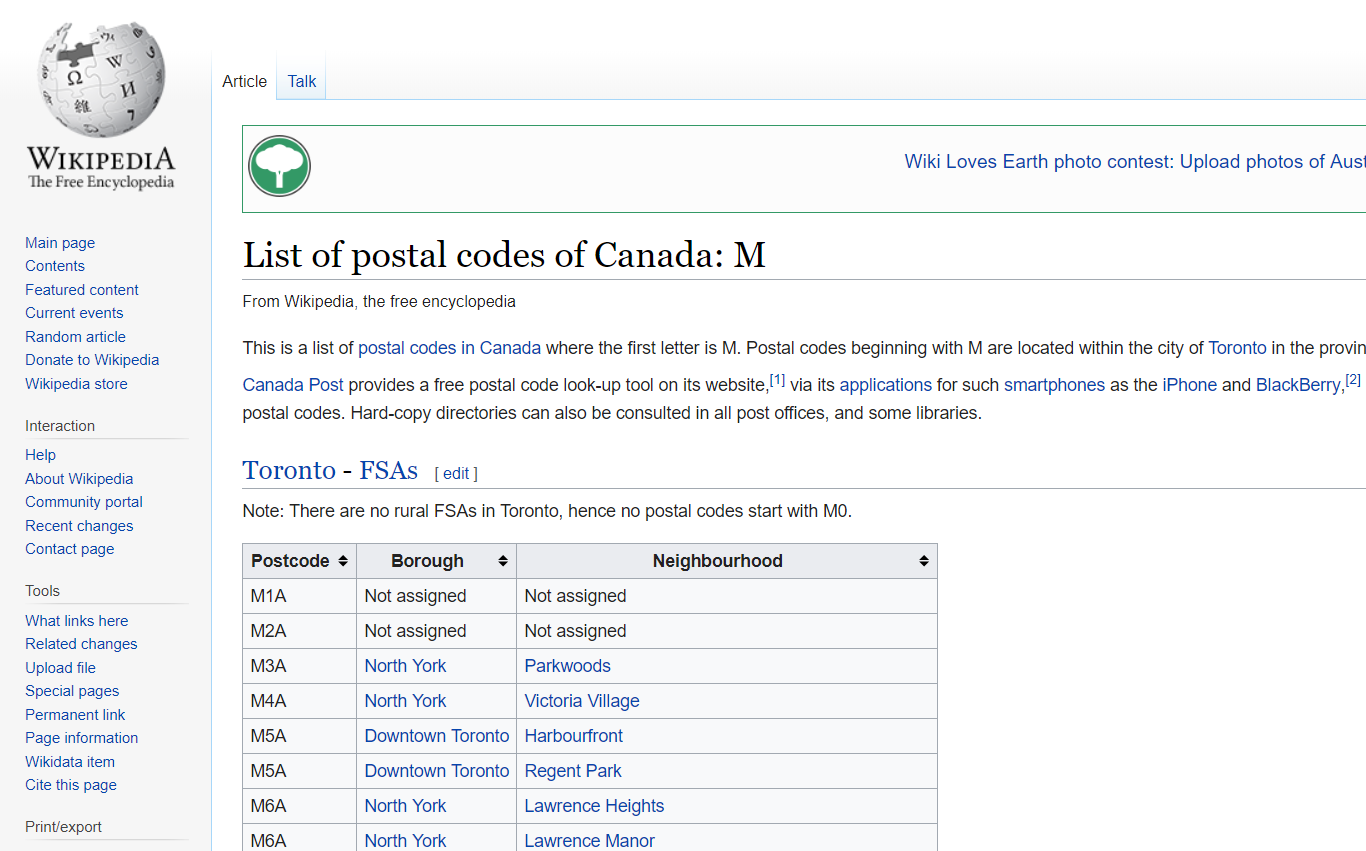

In [1]:
from IPython.display import Image
Image("postal_codes_canada_wikipedia.png")

In [2]:
import requests
import lxml.html as lh
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [3]:
page = requests.get(url)
doc = lh.fromstring(page.content)

In [4]:
tr_elements = doc.xpath('//tr')

In [5]:
type(tr_elements), len(tr_elements)

(list, 294)

In [6]:
print(tr_elements[0].text_content())
print(tr_elements[1].text_content())


Postcode
Borough
Neighbourhood


M1A
Not assigned
Not assigned



In [7]:
data = []
for tr in tr_elements:
    tr_content = tr.text_content().split("\n")
    row = [item for item in tr_content if str(item).strip() != ""]
    if len(row) == 3:
        data.append(row)


Transfer this data to a data frame and do an initial clean.

In [8]:
df = pd.DataFrame(data)
df.columns = df.loc[0].values.tolist()
df.drop(df.index[0], inplace=True)
df = df[df["Borough"] != "Not assigned"]
df.reset_index(inplace=True, drop=True)
df.head(3)

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront


In [9]:
df[df["Neighbourhood"] == "Not assigned"]  # we'll have to adjust for this a bit later...

,Postcode,Borough,Neighbourhood
6,M7A,Queen's Park,Not assigned


More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

In [10]:
pd.options.mode.chained_assignment = None  # default='warn'

postcodes = df["Postcode"].unique()
neighbourhoods = []
boroughs = []
for postcode in postcodes:
    boro = df[df["Postcode"] == postcode]["Borough"].unique().tolist()
    if len(boro) != 1:
        raise ValueError("There should only be one Borough")
    boroughs.append(boro[0])
    
    hood = df[df["Postcode"] == postcode]["Neighbourhood"].unique().tolist()
    neighbourhoods.append(", ".join(hood))

dft = pd.DataFrame({"Postcode": postcodes, "Borough": boroughs, "Neighbourhood": neighbourhoods})

# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 
# specifially, this turns up for M7A, Queen's Park above
borough_tocopy = dft.loc[dft["Neighbourhood"]=="Not assigned"]["Borough"].values.tolist()
print(borough_tocopy)
dft.loc[dft["Neighbourhood"]=="Not assigned", "Neighbourhood"] = borough_tocopy

# rename the postal code column
dft.rename(columns={'Postcode':'PostCode'}, inplace=True)
dft

["Queen's Park"]


,PostCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


We can do a quick check based on the M5A neighbourhood.

In [11]:
dft[dft["PostCode"] == "M5A"]

,PostCode,Borough,Neighbourhood
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"


In [12]:
dft[dft["PostCode"] == "M7A"]  # and also that the neighbourhood adjustment for M7A has gone through

,PostCode,Borough,Neighbourhood
4,M7A,Queen's Park,Queen's Park


In [13]:
dft.shape  # we have 103 rows, 3 columns

(103, 3)

## The [geocoder](https://geocoder.readthedocs.io/index.html) example

In [14]:
import geocoder

In [15]:
# initialize your variable to None
postal_code = "M5G"
lat_lng_coords = None

# loop until you get the coordinates
counter = 0
while(lat_lng_coords is None):
    counter += 1
    g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
    lat_lng_coords = g.latlng
    print("Attempt %d, lat_lng_coords = %s" % (counter, str(lat_lng_coords)))
    if counter >= 10:
        break


Attempt 1, lat_lng_coords = None
Attempt 2, lat_lng_coords = None
Attempt 3, lat_lng_coords = None
Attempt 4, lat_lng_coords = None
Attempt 5, lat_lng_coords = None
Attempt 6, lat_lng_coords = None
Attempt 7, lat_lng_coords = None
Attempt 8, lat_lng_coords = None
Attempt 9, lat_lng_coords = None
Attempt 10, lat_lng_coords = None


So the example they gave us is highly unreliable... we'll have to read from csv instead.

In [16]:
df_coords = pd.read_csv("Geospatial_Coordinates.csv")
df_coords.rename(columns={'Postal Code':'PostCode'}, inplace=True)
df_coords.set_index("PostCode", inplace=True)
df_coords.head(3)

,Latitude,Longitude
PostCode,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711


In [17]:
lat = []
lng = []
for pc in dft["PostCode"].values:
    lat.append(df_coords.at[pc, "Latitude"])
    lng.append(df_coords.at[pc, "Longitude"])

In [18]:
dft["Latitude"] = lat
dft["Longitude"] = lng

dft

,PostCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


Run some checks...

In [19]:
dft[dft["PostCode"] == "M5G"]

,PostCode,Borough,Neighbourhood,Latitude,Longitude
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383


In [20]:
dft[dft["PostCode"] == "M5A"]

,PostCode,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.65426,-79.360636


## Explore and cluster the neighborhoods
First we'll start basic and create a map with the neighbourhoods on top.

Get the libs we need...

In [21]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Get the latitude and longitude for Toronto.

In [22]:
# https://www.latlong.net/place/toronto-on-canada-27230.html
tlat = 43.651070
tlng = -79.347015

In [23]:
dft.columns

Index(['PostCode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude'], dtype='object')

Here we are going to create a basic map for all of our data...

In [24]:
map_toronto = folium.Map(location=[tlat, tlng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dft['Latitude'], dft['Longitude'], dft['Borough'], dft['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

## Filtering the rows to only boroughs that contain the word Toronto

We'll need to keep our login credentials as global variables.

In [25]:
CLIENT_ID = '2NOYPO3T3EULZM4SMI5Q4B00SBBLEYD3LWNYARIQNGQMIPWB'     # your Foursquare ID
CLIENT_SECRET = 'RHT5F4BM1TSDIMA33YRGST1POCB3VZQ2UNNQR2ZC3245Q4UI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2NOYPO3T3EULZM4SMI5Q4B00SBBLEYD3LWNYARIQNGQMIPWB
CLIENT_SECRET:RHT5F4BM1TSDIMA33YRGST1POCB3VZQ2UNNQR2ZC3245Q4UI


As per the project description: Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data.

Here we'll filter the Toronto dataframe to only include boroughs that contain the word 'Toronto'.

This brings us down from 103 rows to 38 rows...

In [26]:
dff = dft[dft["Borough"].str.contains("Toronto")]
dff.head()

,PostCode,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [27]:
len(dff.index)

38

In [28]:
lats = dff["Latitude"].values.tolist()
lngs = dff["Longitude"].values.tolist()
len(lats), len(lngs)

(38, 38)

## A map of these remaining rows

In [29]:
map_toronto = folium.Map(location=[tlat, tlng], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(dff['Latitude'], dff['Longitude'], dff['Borough'], dff['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

## A url for venues
We'll define a function that creates and returns the foursquare venues explore url

In [30]:
def make_venues_url(lat, lng, radius=100, limit=500):
    url = "https://api.foursquare.com/v2/venues/explore?" \
        + "client_id={}".format(CLIENT_ID) \
        + "&client_secret={}".format(CLIENT_SECRET) \
        + "&v={}".format(VERSION) \
        + "&ll={},{}".format(lat, lng) \
        + "&radius={}".format(radius) \
        + "&limit={}".format(limit)
    return url

url = make_venues_url(lats[0], lngs[0])
url

'https://api.foursquare.com/v2/venues/explore?client_id=2NOYPO3T3EULZM4SMI5Q4B00SBBLEYD3LWNYARIQNGQMIPWB&client_secret=RHT5F4BM1TSDIMA33YRGST1POCB3VZQ2UNNQR2ZC3245Q4UI&v=20180605&ll=43.6542599,-79.3606359&radius=100&limit=500'

In [31]:
results = requests.get(url).json()

In [32]:
type(results["response"])

dict

In [33]:
list(results["response"].keys())

['warning',
 'headerLocation',
 'headerFullLocation',
 'headerLocationGranularity',
 'totalResults',
 'suggestedBounds',
 'groups']

In [34]:
results["response"]["totalResults"]

3

## Explore these filtered neighbourhoods
This getNearbyVenues function is directly from the labs... append to a venues list:

In [35]:
LIMIT=500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)


In [36]:
dff.columns

Index(['PostCode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude'], dtype='object')

In [37]:
toronto_venues = getNearbyVenues(names=dff['Neighbourhood'],
                                 latitudes=dff['Latitude'],
                                 longitudes=dff['Longitude'])

Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
Fir

In [38]:
len(toronto_venues), type(toronto_venues)

(1697, pandas.core.frame.DataFrame)

In [39]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront, Regent Park",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Harbourfront, Regent Park",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Harbourfront, Regent Park",43.65426,-79.360636,Toronto Cooper Koo Family Cherry St YMCA Centre,43.653191,-79.357947,Gym / Fitness Center
3,"Harbourfront, Regent Park",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Harbourfront, Regent Park",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [40]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 239 uniques categories.


In [41]:
sorted(toronto_venues['Venue Category'].unique().tolist())[:10]

['Adult Boutique',
 'Afghan Restaurant',
 'Airport',
 'Airport Food Court',
 'Airport Gate',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'American Restaurant',
 'Antique Shop']

So there are 239 unique venue catogories collected ranging from 'Adult Boutique' to 'Antique Shop'.

In [62]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Harbourfront, Regent Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [63]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.0000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.04,0.0,0.0,0.010000,0.01,0.0,0.02,0.0,0.0000,0.0,0.0,0.000000,0.030000,0.0,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.01,0.000000,0.0,0.01,0.020000,0.0000,0.0,0.03,0.010000,0.0,0.0000,0.050000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.010000,0.010000,0.060000,0.0,0.0,0.0,0.01,0.000000,0.0000,0.020000,0.000000,0.03,0.0,0.0,0.000000,0.0,0.01,0.01,0.01,0.01,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.0000

In [64]:
toronto_grouped.shape

(38, 239)

## Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [65]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]


In [66]:
toronto_grouped.columns

Index(['Neighborhood', 'Yoga Studio', 'Adult Boutique', 'Afghan Restaurant',
       'Airport', 'Airport Food Court', 'Airport Gate', 'Airport Lounge',
       'Airport Service', 'Airport Terminal',
       ...
       'Thrift / Vintage Store', 'Toy / Game Store', 'Trail', 'Train Station',
       'Vegetarian / Vegan Restaurant', 'Video Game Store',
       'Vietnamese Restaurant', 'Wine Bar', 'Wings Joint', 'Women's Store'],
      dtype='object', length=239)

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,Bar,Steakhouse,American Restaurant,Hotel,Cosmetics Shop,Burger Joint,Bakery
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Cheese Shop,Café,Restaurant,Farmers Market,Seafood Restaurant,Beer Bar,Bakery
2,"Brockton, Exhibition Place, Parkdale Village",Café,Breakfast Spot,Coffee Shop,Gym,Bar,Caribbean Restaurant,Italian Restaurant,Furniture / Home Store,Stadium,Burrito Place
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Comic Shop,Pizza Place,Restaurant,Butcher,Burrito Place,Brewery,Skate Park,Farmers Market
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boat or Ferry,Sculpture Garden,Plane,Boutique,Airport Gate,Airport


So we have our top 10 venues by neighbourhood. Now we'll look at clustering.

## Cluster Neighborhoods

In [68]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dff.copy().rename(columns={'Neighbourhood':'Neighborhood'})

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,0,Coffee Shop,Pub,Bakery,Park,Mexican Restaurant,Theater,Breakfast Spot,Café,Gym / Fitness Center,Historic Site
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Theater,Bakery,Bubble Tea Shop,Italian Restaurant,Ramen Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Restaurant,Hotel,Cosmetics Shop,Breakfast Spot,Clothing Store,Bakery,Gastropub,Diner
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Dessert Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Steakhouse,Cheese Shop,Café,Restaurant,Farmers Market,Seafood Restaurant,Beer Bar,Bakery


## Visualising the clusters

In [70]:
tlat, tlng

(43.65107, -79.347015)

In [71]:
# create map
map_clusters = folium.Map(location=[tlat, tlng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examining clusters
What are the discriminating venue categories from our basic setup? I'd place these as coffee shops / bars / restaurants into one cluster, playgrounds into another, then swim schools and general services... 

In [79]:
c1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
c1.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,0,Coffee Shop,Pub,Bakery,Park,Mexican Restaurant,Theater,Breakfast Spot,Café,Gym / Fitness Center,Historic Site
9,Downtown Toronto,0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Theater,Bakery,Bubble Tea Shop,Italian Restaurant,Ramen Restaurant
15,Downtown Toronto,0,Coffee Shop,Café,Restaurant,Hotel,Cosmetics Shop,Breakfast Spot,Clothing Store,Bakery,Gastropub,Diner
19,East Toronto,0,Health Food Store,Trail,Pub,Dessert Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
20,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Steakhouse,Cheese Shop,Café,Restaurant,Farmers Market,Seafood Restaurant,Beer Bar,Bakery


In [75]:
c2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
c2.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
83,Central Toronto,1,Park,Playground,Trail,Tennis Court,Women's Store,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant
91,Downtown Toronto,1,Park,Playground,Trail,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop


In [76]:
c3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
c3.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Central Toronto,2,Park,Swim School,Bus Line,Women's Store,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [77]:
c4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
c4.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,3,Garden,Home Service,Women's Store,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


***